In [1]:
# installing dependencies
import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install scipy

In [2]:
# importing dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy
import re

%matplotlib inline

# Read in the data

In [3]:
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    print(f)
    d = pd.read_csv("data-master/nyc-sat-scores/schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

ap_2010.csv
class_size.csv
demographics.csv
graduation.csv
hs_directory.csv
sat_results.csv


# Read in the surveys

In [4]:
all_survey = pd.read_csv("data-master/nyc-sat-scores/schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("data-master/nyc-sat-scores/schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [5]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [6]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [7]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [8]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [9]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [10]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [11]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [12]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

<AxesSubplot:>

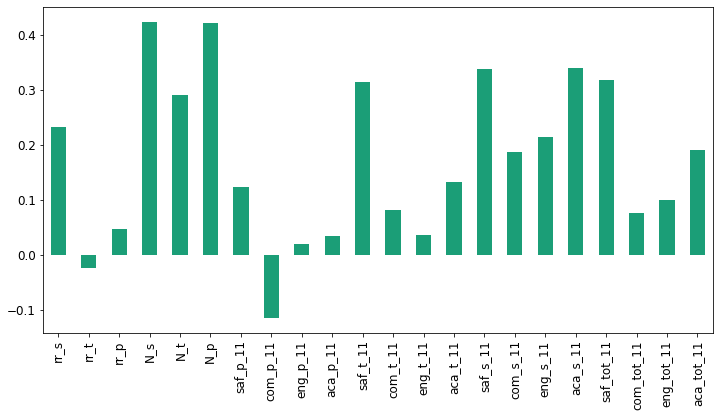

In [13]:
correlations[survey_fields].plot(kind="bar", colormap="Dark2", figsize=(12,6),fontsize=12)

## Observations


From the figure above is clear that are two strong positive correlations with nyc students sat scores and the surveys results:
* N_s: Number of students respondents.
* N_p: Number of parent repondents.
* N_t: Number of teacher repondents.

Which can be interpreted as: _The more students, parents and teachers responded the survey, the better is the average sat scores for that school._

The other noticeable positive correlations are with:
* saf_t_11: Safety and Respect score based on teacher responses.
* saf_s_11: Safety and Respect score based on student responses.
* saf_tot_11: Safety and Respect total score.

Which can be interpreted as: _The higher perception of safety and respect from students and teachers, the better is the average sat scores for that school._

Lastly it was found that _aca_s_10_ which accounts for Academic Spectations has also a high positive correlation with the average sat scores for that school.




# Ploting the school safety perception 

<AxesSubplot:xlabel='saf_s_11', ylabel='sat_score'>

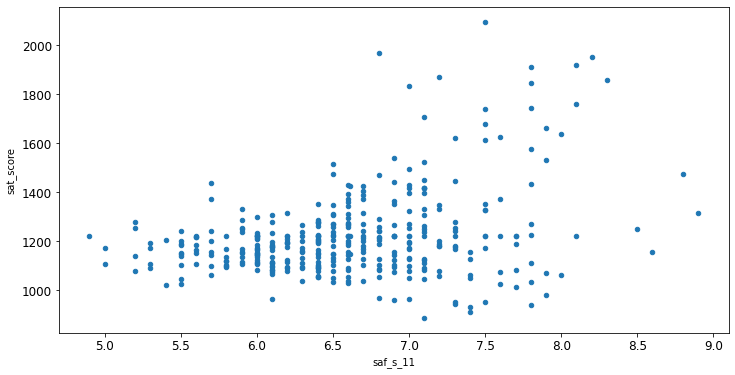

In [14]:
combined.plot(kind="scatter", x="saf_s_11", y="sat_score", figsize=(12,6),fontsize=12)

## Observations

In the plot above of school safety perception vs sat score we can see that there is indeed a tendency of better results with higher safety perception. Although in the highest end of safety are few data points is fair to asume that with more data the scattered positions of the rightmost part of the plot would be filled accordingly the leftmost part.

# Ploting boroughs

               saf_s_11
boro                   
Bronx          6.606577
Brooklyn       6.370755
Manhattan      6.831370
Queens         6.721875
Staten Island  6.530000


<AxesSubplot:xlabel='boro'>

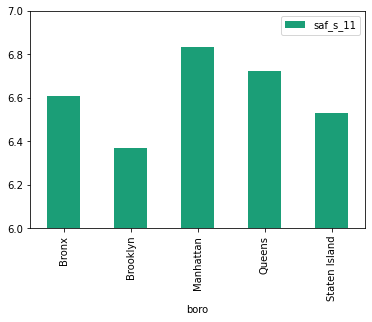

In [15]:
borough_avg_scores = combined[["boro", "saf_s_11"]].groupby(["boro"]).agg(numpy.mean)

print(borough_avg_scores.head())

borough_avg_scores.plot(kind="bar", ylim=(6, 7), colormap="Dark2")

# Observations 
As seen above Manhattan is perceived as the most safe followed by Queens, while Brookling is by far the worst perceived.

# Racial correlations

<AxesSubplot:>

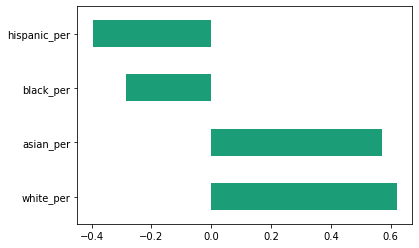

In [16]:
race_cols=["white_per", "asian_per", "black_per", "hispanic_per"]
correlations[race_cols].plot(kind="barh", colormap="Dark2" )

It's easy to detect that there is a strong negative correlation for the hispanic and black population of ny students, while there is a strong positive correlation for the asian and white studends.

<AxesSubplot:xlabel='hispanic_per', ylabel='sat_score'>

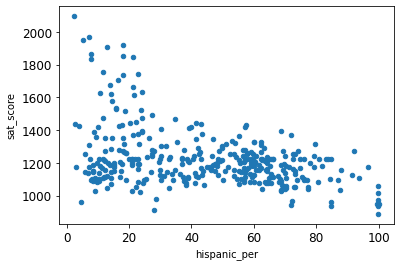

In [17]:
combined.plot(x="hispanic_per", y="sat_score", kind="scatter",fontsize=12)

An interesting finding is that hispanic stdent population has low average sat score.

## Schools with a high hispanic population

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

In [53]:
combined[combined["hispanic_per"] > 95][["SCHOOL NAME"]]

,SCHOOL NAME
44,MANHATTAN BRIDGES HIGH SCHOOL
82,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125,ACADEMY FOR LANGUAGE AND TECHNOLOGY
141,INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253,MULTICULTURAL HIGH SCHOOL
286,PAN AMERICAN INTERNATIONAL HIGH SCHOOL


It appear tha those schools have a high inmigrant population.

In [54]:
combined[ (combined["hispanic_per"] < 10) & (combined["sat_score"] > 1000) ][["SCHOOL NAME"]]

,SCHOOL NAME
37,STUYVESANT HIGH SCHOOL
46,HIGH SCHOOL FOR DUAL LANGUAGE AND ASIAN STUDIES
151,BRONX HIGH SCHOOL OF SCIENCE
187,BROOKLYN TECHNICAL HIGH SCHOOL
192,BEDFORD ACADEMY HIGH SCHOOL
194,BENJAMIN BANNEKER ACADEMY
220,BOYS AND GIRLS HIGH SCHOOL
223,ACADEMY FOR COLLEGE PREPARATION AND CAREER EXP...
226,THE HIGH SCHOOL FOR GLOBAL CITIZENSHIP
227,"SCHOOL FOR HUMAN RIGHTS, THE"


The schools above appear to be very technical, which could led us to assume having better funding.

# Gender correlations

<AxesSubplot:>

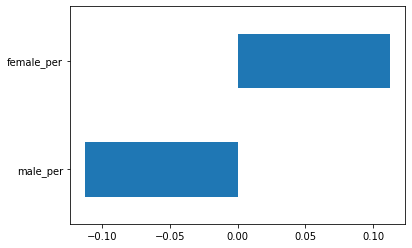

In [82]:
correlations[["male_per", "female_per"]].plot(kind="barh")

Well...altough the correlations are quite weak, there is a clear tendency of women scoring better results than men.

<AxesSubplot:ylabel='Density'>

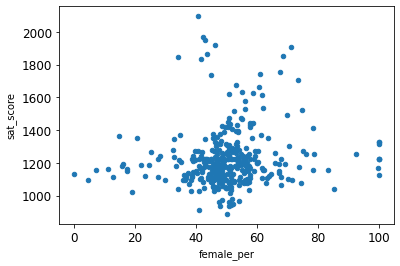

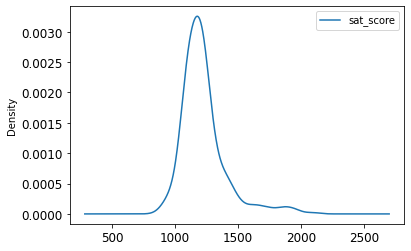

In [84]:
combined.plot(x="female_per", y="sat_score", kind="scatter", fontsize=12)
combined.plot(x="female_per", y="sat_score", kind="kde", fontsize=12)

There is no noticeable linear correlations between women percentage an high scores, instead there is a big cluster of good results close to the mean.

In [88]:
# Research any schools with a female_per greater than 60% and an average SAT score greater than 1700

combined[ (combined["female_per"] > 60) & (combined["sat_score"] > 1700)  ][["SCHOOL NAME", "sat_score" ]]

,SCHOOL NAME,sat_score
5,BARD HIGH SCHOOL EARLY COLLEGE,1856.0
26,ELEANOR ROOSEVELT HIGH SCHOOL,1758.0
60,BEACON HIGH SCHOOL,1744.0
61,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,1707.0
302,TOWNSEND HARRIS HIGH SCHOOL,1910.0


It looks that these schools have an strong orientation for the liberal arts.

# AP test correlation

<AxesSubplot:xlabel='took_ap', ylabel='sat_score'>

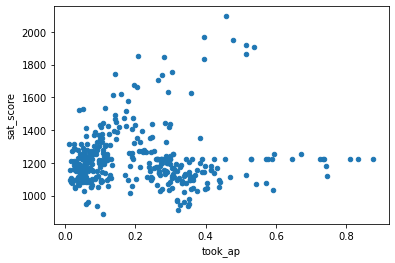

In [100]:
# Calculate the percentage of students in each school that took an AP exam.
# Divide the AP Test Takers column by the total_enrollment column.
# The column name AP Test Takers has a space at the end -- don't forget to add it!
# Investigate the relationship between AP scores and SAT scores.
# Make a scatter plot of ap_per vs. sat_score.

combined["took_ap"] = combined["AP Test Takers "] / combined["total_enrollment"] 
combined.plot(x="took_ap", y="sat_score", kind="scatter")

It also appear that higher AP test takers doesn't mean higher sat scores, there are at least two tendencies that contradict each other, the only noticeable pattern is the cluster at the leftmost bottom corner of the plot